# 미니 프로젝트 분석 보고서

In [2]:
# import 모듈
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

# 명시적 대기
from selenium.webdriver.support.ui import WebDriverWait # 웹드라이버
from selenium.webdriver.support import expected_conditions as EC # 특정한 상태를 기다리는 라이브러리
from selenium.common.exceptions import ElementNotInteractableException

from scipy import stats
# 통계모델들...
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# windows 용 한글 폰트 오류 해결
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc("font", family = font_name)

# 글 불러오기 
pet_selected_df = pd.read_excel("final_mini_project.xlsx")

## 좋은 사료 기준 (성분관련)
- 조단백이 20퍼가 넘어야함
- 조지방이 8퍼 넘어야함
## 시각화
- 타입별 구성성분 분석표(비교 시각화 파트)
- 구성성분과 가격과의 상관관계 유무
- 브랜드 별 구성성분 분석표(비교 시각화 파트)

## 성분과 가격의 상관관계

In [3]:
# 필요한 컬럼만 뽑습니다
related = pet_selected_df[["브랜드","상품이름","가격","타입","조단백","조지방","조섬유","조회분","칼슘","인","수분","무게대비가격"]]

In [4]:
related.columns

Index(['브랜드', '상품이름', '가격', '타입', '조단백', '조지방', '조섬유', '조회분', '칼슘', '인', '수분',
       '무게대비가격'],
      dtype='object')

In [5]:
# 브랜드로 묶어서 성분의 평균을 구합니다.
type_group = related.groupby("타입")[["조단백","조지방","조섬유","조회분","칼슘","인","수분"]].mean().sort_values("조단백",ascending = False)
# 성분의 구성의 비율을 보기 위해 파이차트를 그립니다
protein_pie = type_group[type_group["조단백"] != 0][:5]
protein_pie

,조단백,조지방,조섬유,조회분,칼슘,인,수분
타입,,,,,,,
소프트(반건조),22.930000,8.717317,0.829268,1.853659,0.156098,0.095122,4.926829
동결건조,20.555556,10.888889,0.000000,0.000000,0.000000,0.000000,0.000000
건식,19.984716,10.306117,2.321631,3.977128,0.430078,0.307674,4.948582
화식,11.600000,3.428125,0.000000,0.000000,0.000000,0.000000,0.000000
습식,6.314414,3.128018,0.954234,1.297928,0.072991,0.074595,57.218919


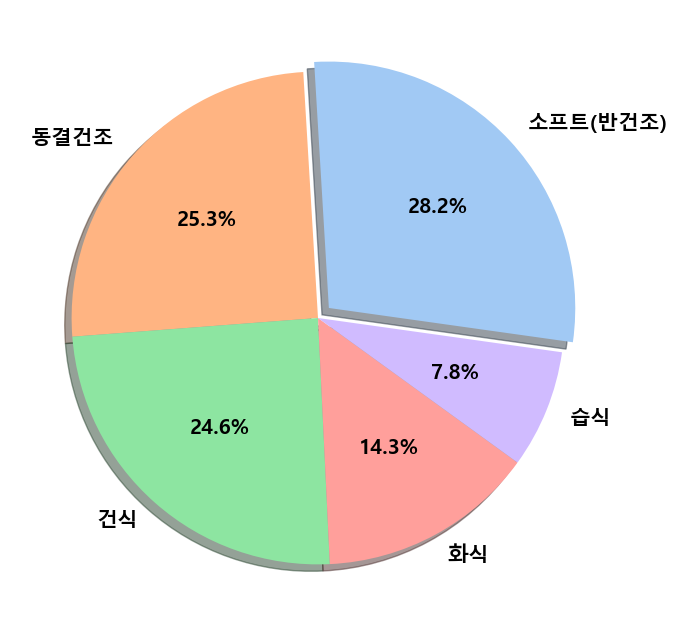

In [6]:
# 성분 평균 파이차트
fig = plt.figure(figsize=(10,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임 생성

colors = sns.color_palette('pastel')[0:10]
labels = protein_pie.index

explode = [0.06,0,0,0,0]
labels = ['소프트(반건조)', '동결건조', '건식', '화식', '습식']




# font 
font = {
    'weight' : 'bold',
    'size'   : 15
}

plt.rc('font', **font)
ax.pie(
    protein_pie["조단백"],
    labels=labels,
    explode = explode,
    colors = colors, 
    autopct='%.1f%%',
    startangle=-8,
    shadow = True
    
)

#plt.legend()
#plt.title("사료 건조 분류에 따른 조단백 평균 함유량", size =20)
plt.savefig("사료 건조 분류에 따른 조단백 평균 함유량.png")
plt.show()

- 반건조, 동결건조, 건식 순으로 조단백 성분이 높음!

In [9]:
# 타입으로 묶어서 조지방의 평균을 구하기
type_group_2 = related.groupby("타입")[["조지방"]].mean().sort_values("조지방",ascending = False)
fat_pie = type_group_2[type_group_2["조지방"] != 0]
fat_pie

,조지방
타입,
동결건조,10.888889
건식,10.306117
소프트(반건조),8.717317
화식,3.428125
습식,3.128018
반건조(소프트건식),0.236364


Index(['동결건조', '건식', '소프트(반건조)', '화식', '습식', '반건조(소프트건식)'], dtype='object', name='타입')


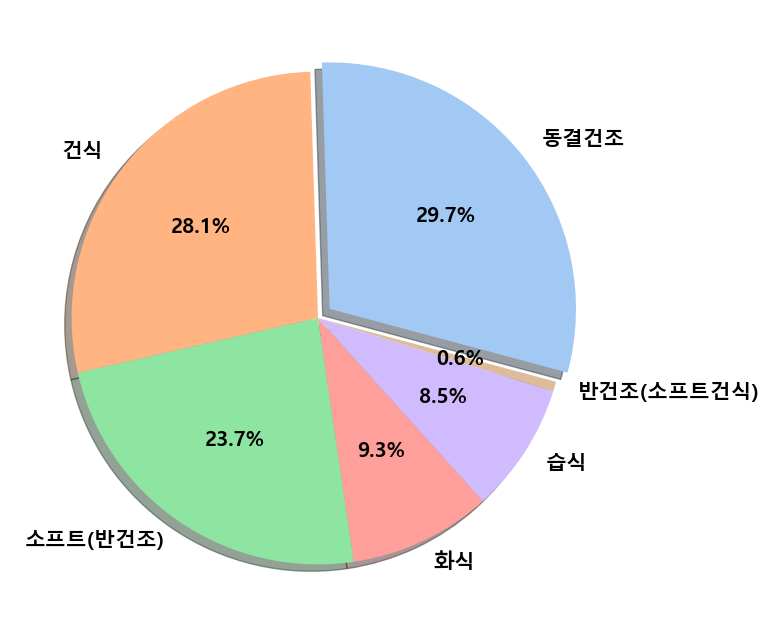

In [8]:
# 성분 평균 파이차트
fig = plt.figure(figsize=(10,8)) ## 캔버스 생성
fig.set_facecolor('white') ## 캔버스 배경색을 하얀색으로 설정
ax = fig.add_subplot() ## 프레임 생성

colors = sns.color_palette('pastel')[0:10]
labels = fat_pie.index
print(labels)
explode = [0.06,0,0,0,0,0]
labels = ['동결건조', '건식', '소프트(반건조)', '화식', '습식', '반건조(소프트건식)']
ax.pie(
    fat_pie["조지방"],
    labels=labels,
    explode = explode,
    colors = colors, 
    autopct='%.1f%%',
    startangle=-15,
    shadow = True
)
# plt.title("사료 건조 분류에 따른 조지방 평균 함유량", size =20)
plt.savefig("사료 건조 분류에 따른 조지방 평균 함유량.png")
plt.show()

- 동결건조, 건식, 반건조 순으로 지방함량이 많음

# 성분과 가격의 상관관계

In [11]:
# 가격과 성분들의 상관관계가 있는지 알기위해 전처리
chart_data_selected = related.head(10).sort_values("가격")
chart_data_selected["무게대비가격"] = chart_data_selected["무게대비가격"].fillna(0)

In [12]:
chart_data_selected.head()

,브랜드,상품이름,가격,타입,조단백,조지방,조섬유,조회분,칼슘,인,수분,무게대비가격
6,로얄캐닌,독 유리너리 S/O 캔 410g,7990,습식,6.0,4.0,2.4,2.2,0.01,0.01,81.0,19488.0
7,도그랑,클래식 5kg,9090,건식,25.0,10.0,0.0,0.0,0.00,0.00,0.0,1818.0
4,도그라인,아지피아 20kg,39240,건식,32.0,20.0,3.0,13.0,1.00,0.80,14.0,1962.0
8,로얄캐닌,엑스스몰 어덜트 3kg,40580,건식,24.0,18.0,0.0,0.0,0.00,0.00,0.0,13527.0
9,뉴트리나,건강백서 건강한 6세이상 10.2kg,50380,건식,27.0,12.0,5.0,10.0,1.00,0.60,12.0,4939.0


In [9]:
print("조단백 : ", stats.ttest_rel(chart_data_selected["무게대비가격"],chart_data_selected["조단백"]).pvalue)
print("조지방 : ", stats.ttest_rel(chart_data_selected["무게대비가격"],chart_data_selected["조지방"]).pvalue)
# print("조회분 : ", stats.ttest_rel(chart_data_selected["무게대비가격"],chart_data_selected["조회분"]).pvalue)
# print("칼슘 : ", stats.ttest_rel(chart_data_selected["무게대비가격"],chart_data_selected["칼슘"]).pvalue)
# print("인 : ", stats.ttest_rel(chart_data_selected["무게대비가격"],chart_data_selected["인"]).pvalue)
# print("수분 : ", stats.ttest_rel(chart_data_selected["무게대비가격"],chart_data_selected["수분"]).pvalue)

조단백 :  0.001394817833648077
조지방 :  0.0013809627788728812


- 귀무가설 : 가격의 평균과 조단백의 평균은 유의미한 차이가 없다.
- 대립가설 : 가격과 조단백 퍼센트는 상관관계가 있다.
- p_value : 0.05 미만이므로 가격과 조단백 퍼센트는 상관관계가 있다!!!!
- **원료가 많이 들어가 있을수록 가격이 올라가는 추세이다~~**

## 하지만! 성분도 챙기고 가격도 합리적인 상품을 찾고싶다!

### 브랜드 비교를 위해 산점도 그릴 준비

In [15]:
pet_selected_df.columns

Index(['브랜드', '상품이름', '가격', '연령', '타입', '별점', '리뷰개수', '주원료', '조단백', '조지방',
       '조섬유', '조회분', '칼슘', '인', '수분', '무게', '무게_환산', '무게대비가격'],
      dtype='object')

In [21]:
# 조단백 / 가격 / hue 회사명
protein_max = pet_selected_df["조단백"].max()
protein_mean = pet_selected_df["조단백"].mean()

price_max = pet_selected_df["가격"].max()
price_mean = pet_selected_df["가격"].mean()

fat_max = pet_selected_df["조지방"].max()
fat_mean = pet_selected_df["조지방"].mean()

print("protein_max : " , protein_max)
print("protein_mean : " , protein_mean)
print("-----------------")
print("price_max : " , price_max)
print("price_mean : " , price_mean)
print("-----------------")
print("fat_max : " , fat_max)
print("fat_mean : " , fat_mean)

# 기준 필터링( 조단백 20 이상 조지방 8이상인 상품을 무게대비가격순으로 8개 출력)
filtering = pet_selected_df[
(pet_selected_df["조단백"] >= 20) & (pet_selected_df["조지방"] >= 8) &
(pet_selected_df["주원료"].str.contains("닭","오리"))
].sort_values("무게대비가격").head(8)

protein_max :  46.6
protein_mean :  15.204666666666668
-----------------
price_max :  737000
price_mean :  42343.64
-----------------
fat_max :  30.0
fat_mean :  7.640344444444445


In [19]:
# 도그랑 1위!!
filtering.reset_index(drop=True)[["브랜드","상품이름","조단백","무게대비가격","주원료"]]

,브랜드,상품이름,조단백,무게대비가격,주원료
0,도그라인,뉴 특수견 15kg,27.0,1433.0,"과일,야채, 닭"
1,천하제일,풍월 20kg,26.0,1656.0,"과일,야채, 닭"
2,뉴트리나,프라임 퍼포먼스 20kg,30.0,1674.0,"과일,야채, 닭"
3,도그랑,클래식 5kg,25.0,1818.0,닭
4,천하제일,풍월 15kg,26.0,1841.0,"과일,야채, 닭"
5,뉴트리나,프라임 퍼포먼스 플러스 20kg,30.0,1927.0,"과일,야채, 닭"
6,도그라인,도그피아 20kg,32.0,1936.0,"과일,야채, 닭"
7,도그라인,아지피아 20kg,32.0,1962.0,"과일,야채, 닭"


##  산점도로 브랜드 비교

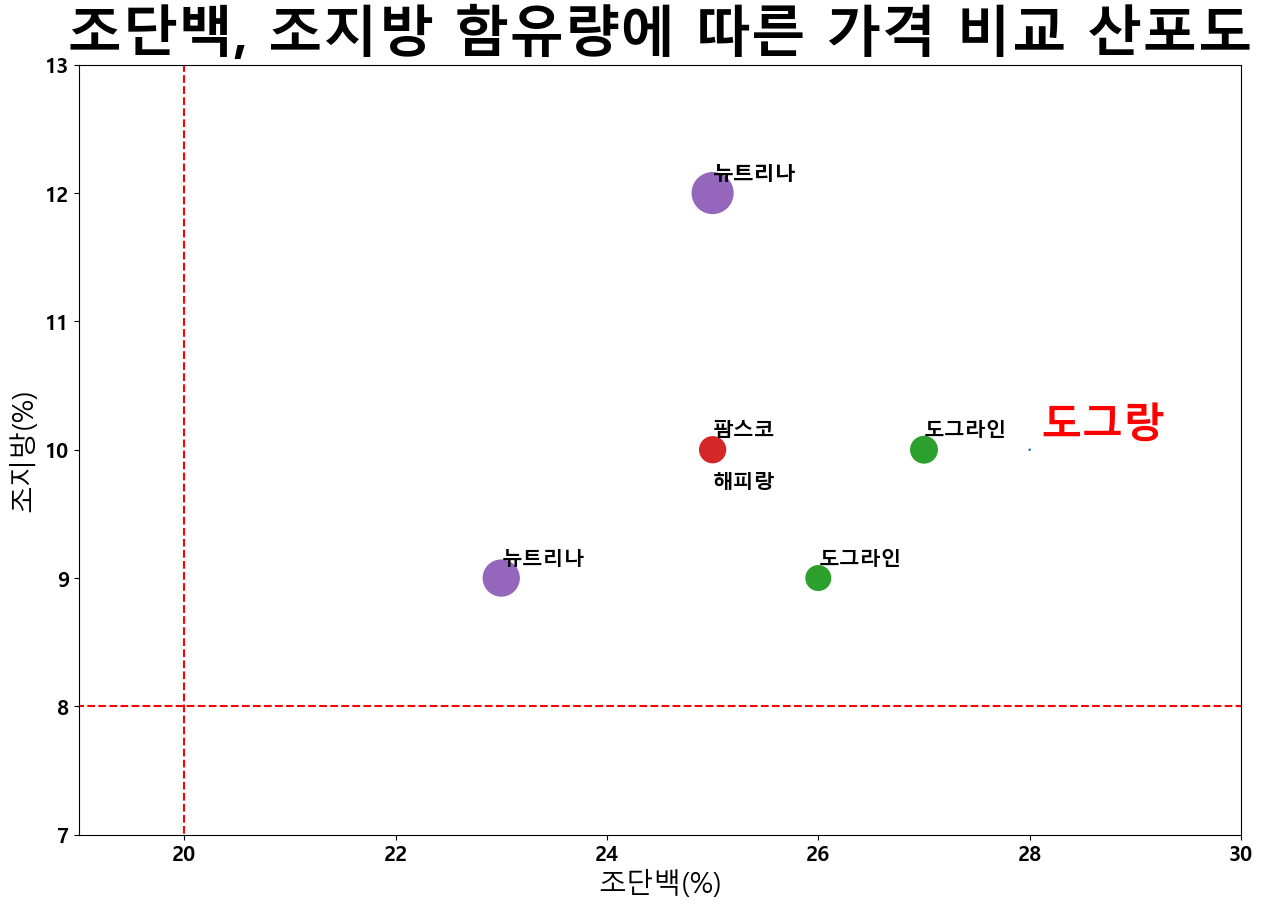

In [21]:
plt.figure(figsize = (15,10))
plt.title("브랜드 별 가격과 조단백의 산점도")

# font 
font = {
        'size'   : 15
}
ax = sns.scatterplot(
    x = "조단백",
    y = "조지방",
    size = "무게대비가격",
    hue = filtering["브랜드"],
    data = filtering,
    sizes = (10, 1000), # 크기의 범위
    legend = False,
)
# 조단백 20 이상 
# 조지방 6 이상 

# 절취선 
plt.plot(
    [20, 20],
    [0,fat_max], 
    "r--"
)

plt.plot(
    [0, protein_max],
    [8,8], 
    "r--"
)
plt.xlim(19,30)
plt.ylim(7,13)

for idx, row in filtering.iterrows():
    x = row["조단백"]
    y = row["조지방"]
    z = row["브랜드"].split()[0]
    if idx == 103:
        plt.text(x+0.1, y+0.1, z, size = 30, color = "red")
    elif idx == 270 : 
        plt.text(x, y-0.3, z, size = 15)
    else : 
        plt.text(x, y+0.1, z, size = 15)

ax.set_title(
    "조단백, 조지방 함유량에 따른 가격 비교 산포도",
    fontsize=40,
    fontweight="bold",
)
ax.set_xlabel("조단백(%)",fontsize=20)
ax.set_ylabel("조지방(%)",fontsize=20)

plt.yticks(size=15)
plt.xticks(size=15)

plt.savefig("브랜드 별 가격과 성분 비교.png")
plt.show()

- 가성비 브랜드로는 도그랑이 1위이다.

In [14]:
filtering.head()

,브랜드,상품이름,가격,연령,타입,별점,리뷰개수,주원료,조단백,조지방,조섬유,조회분,칼슘,인,수분,무게,무게_환산,무게대비가격
103,도그랑,파워 스페셜 15kg,20060,주니어,건식,4.6,0,"과일,야채",28.0,10.0,0.0,0.0,0.00,0.0,0.0,15kg,15.0,1337.0
88,팜스코,도그닥터 특수견 15kg,21160,전연령,건식,4.7,0,NaN,25.0,10.0,0.0,0.0,0.00,0.0,0.0,15kg,15.0,1411.0
281,도그라인,특수견 플러스 15kg,21310,주니어,건식,4.6,0,"과일,야채",26.0,9.0,6.0,12.0,0.95,1.9,10.0,15kg,15.0,1421.0
270,해피랑,파워특수견 15kg,21440,전연령,건식,4.8,0,"과일,야채",25.0,10.0,0.0,0.0,0.00,0.0,0.0,15kg,15.0,1429.0
42,도그라인,뉴 특수견 15kg,21500,어덜트,건식,4.7,0,"과일,야채, 닭",27.0,10.0,5.5,11.5,0.90,0.6,14.0,15kg,15.0,1433.0


In [22]:
# barplot 으로 보여주기위해 데이터 전처리
bar_chart_data = chart_data_selected.groupby("브랜드").mean(numeric_only = True)[["조단백","조지방","조섬유","칼슘","인","수분","무게대비가격"]].sort_values("조단백", ascending = False)

# 가격이 제일 착한순 
price_sort_values = filtering.groupby("브랜드").mean(numeric_only = True)[["조단백","무게대비가격"]].sort_values("무게대비가격")

# 조단백 성분이 많이 들어있는순
protein_values = filtering.groupby("브랜드").mean(numeric_only = True)[["조단백"]].sort_values("조단백", ascending = False)

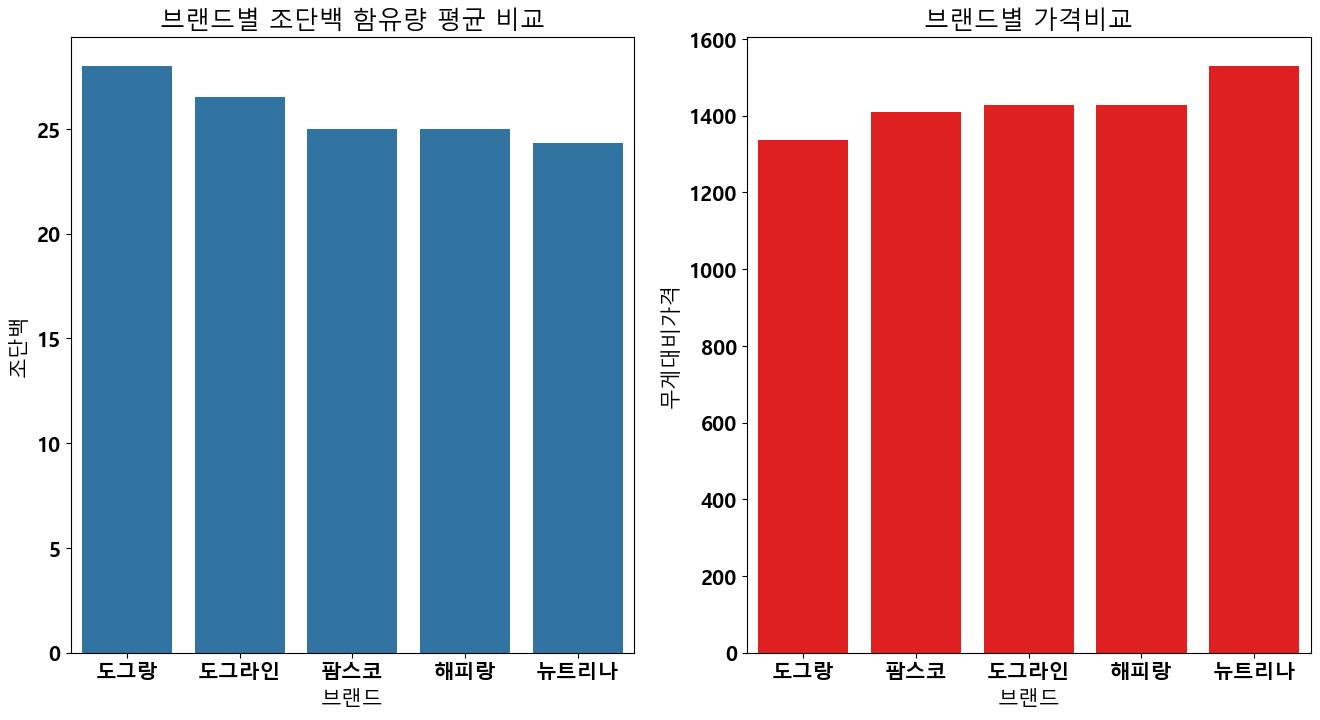

In [24]:
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sns.barplot(
    data = protein_values,
    x = "브랜드",
    y = "조단백",
    ax = ax1,
)

sns.barplot(
    data = price_sort_values,
    x = "브랜드",
    y = "무게대비가격",
    color = "r",
    ax = ax2
)

#ax1.legend()
# 차트 제목
ax1.set_title("브랜드별 조단백 함유량 평균 비교")
ax2.set_title("브랜드별 가격비교")

plt.savefig("브랜드비교.png")
plt.show()

- 성분과 가격을 모두 챙긴 도그랑 사료가 좋다!

# 피드백

In [14]:
# ttest_rel는 무게대비가격 의 평균 조단백의 "평균의 차이"를 보려고 쓰는것임! 
# 상관계수는 피어슨을 사용해라!
stats.pearsonr(chart_data_selected["무게대비가격"], chart_data_selected["조단백"])

# 순서 : 데이터 탐색을 충분히 하고 나서 타당성을 입증할때 검정통계를 하는것이다!
# ex) 음의 상관관계를 설명하고 싶을때 이거 찍어서 보여주셈

PearsonRResult(statistic=np.float64(-0.6947559213776136), pvalue=np.float64(0.02576113036842189))

In [15]:
# 분석을 한 이유를 생각하면서 결론을 내야한다!!!!!!!!!!!!!!!!!!!!!story story maple story~ maple story~ 